## 1. Overall

In [4]:
import os, sys, time, warnings
import pandas as pd
import seaborn as sns
import datetime as dt
import lightgbm as lgb
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import heapq

sys.path.append(os.path.abspath(os.path.dirname("../")))
from modules import edaViz

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
%%time
histTrans = pd.read_hdf("../dataset/edaViz/histTrans.h5", "histTrans")
trainLabels = pd.read_hdf("../dataset/edaViz/train.h5", "train")
testLabels = pd.read_hdf("../dataset/edaViz/testEdaViz.h5", "testEdaViz")

Wall time: 51.6 s


In [5]:
edaViz.printInfo('histTrans',histTrans)
edaViz.printDescribe('histTrans',histTrans)

histTrans information :  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         bool
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: bool(1), float64(2), int64(6), object(5)
memory usage: 3.1+ GB


histTrans Describe :  
             city_id  installments  merchant_category_id     month_lag  \
count  2.911236e+07  2.911236e+07          2.911236e+07  2.911236e+07   
mean   1.293256e+02  6.484954e-01          4.810130e+02 -4.487294e+00   
std    1.042563e+02  2.795577e+00          2.493757e+02  3.588800e+00   
min   -1.000000e+00 -1.000000e+00        

In [31]:
trainLabels.to_hdf("../dataset/edaViz/trainEdaViz.h5", "trainEdaViz")
testLabels.to_hdf("../dataset/edaViz/testEdaViz.h5", "testEdaViz")

In [ ]:
histTransCount = Counter(histTrans['card_id'])
trainLabels['transCount'] = trainLabels['card_id'].apply(lambda row: histTransCount[row])
testLabels['transCount'] = testLabels['card_id'].apply(lambda row: histTransCount[row])

In [5]:
print(trainLabels.head(10))
print(testLabels.head(10))

   first_active_month          card_id  feature_1  feature_2  feature_3  \
0                   6  C_ID_92a2005557          5          2          1   
1                   1  C_ID_3d0044924f          4          1          0   
2                   8  C_ID_d639edf6cd          2          2          0   
3                   9  C_ID_186d6a6901          4          3          0   
4                  11  C_ID_cdbd2c0db2          1          3          0   
5                   9  C_ID_0894217f2f          4          2          0   
6                  12  C_ID_7e63323c00          3          2          1   
7                   9  C_ID_dfa21fc124          3          2          1   
8                   8  C_ID_fe0fdac8ea          2          1          0   
9                   8  C_ID_bf62c0b49d          2          2          0   

     target  lowerBound  first_active_year  transCount  authCount  authRatio  \
0 -0.820283       False               2017         260      247.0   0.950000   
1  0.392913   

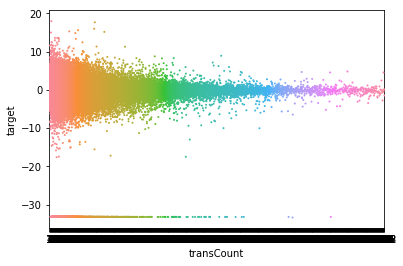

In [5]:
sns.stripplot(x=trainLabels['transCount'], y=trainLabels['target'], size=2)

## 2. authorized flag

In [17]:
edaViz.printUniqCount(histTrans[['authorized_flag']])

authorized_flag Unique :  
 ['Y' 'N'] 

authorized_flag Count :  
 Y    26595452
N     2516909
Name: authorized_flag, dtype: int64 




In [28]:
histTrans['authorized_flag'] = (histTrans['authorized_flag']=='Y')
histTrans.to_hdf("../dataset/edaViz/histTrans.h5", key='histTrans', mode='w')

c:\elo\py36\lib\site-packages\pandas\core\generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['card_id', 'category_1', 'category_3', 'merchant_id', 'purchase_date']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [4]:
%%time
authGroup= histTrans[['card_id', 'authorized_flag']].groupby(['card_id'])
trainLabels['authCount'] = edaViz.mergeGroupby(trainLabels, authGroup['authorized_flag'], np.sum)
trainLabels['authRatio'] = trainLabels['authCount'] / trainLabels['transCount']
testLabels['authCount'] = edaViz.mergeGroupby(testLabels, authGroup['authorized_flag'], np.sum)
testLabels['authRatio'] = testLabels['authCount'] / testLabels['transCount']

Wall time: 10.4 s


In [29]:
print('authCount Null : ',trainLabels['authCount'].isna().sum())
print('authRatio Null : ',testLabels['authRatio'].isna().sum())

authCount Null :  0
authRatio Null :  0


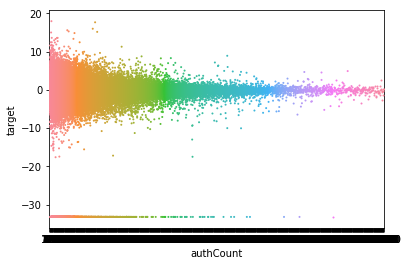

In [10]:
sns.stripplot(x=trainLabels['authCount'], y=trainLabels['target'], size=2)

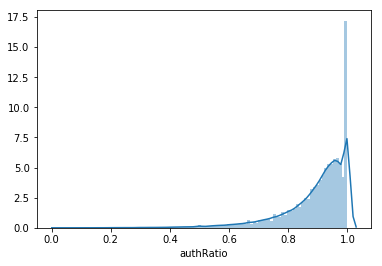

In [12]:
sns.distplot(trainLabels['authRatio'],bins=100)

In [24]:
print('1 : ', trainLabels['card_id'][trainLabels['authRatio']==1].count())
for i in range(10):
    lower = i/10
    higher = (i+1)/10
    print('over {} ~ under {} : {}'.format(lower, higher,
        trainLabels['card_id'][trainLabels['authRatio']>=lower][trainLabels['authRatio']<higher].count()))

1 :  30959
over 0.0 ~ under 0.1 : 13
over 0.1 ~ under 0.2 : 82
over 0.2 ~ under 0.3 : 296
over 0.3 ~ under 0.4 : 618
over 0.4 ~ under 0.5 : 1380
over 0.5 ~ under 0.6 : 3539
over 0.6 ~ under 0.7 : 7730
over 0.7 ~ under 0.8 : 17325
over 0.8 ~ under 0.9 : 46229
over 0.9 ~ under 1.0 : 93746


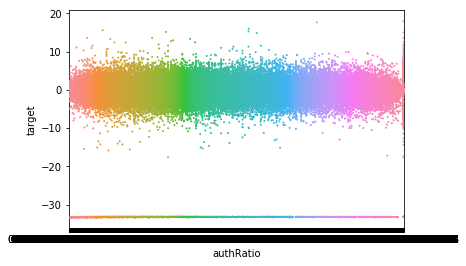

In [4]:
sns.stripplot(x=trainLabels['authRatio'], y=trainLabels['target'], size=2)

Wall time: 2min 20s


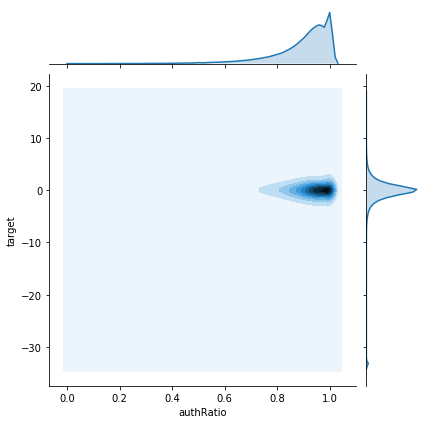

In [21]:
%time sns.jointplot(x=trainLabels['authRatio'], y=trainLabels['target'], kind='kde')

Wall time: 21.7 s


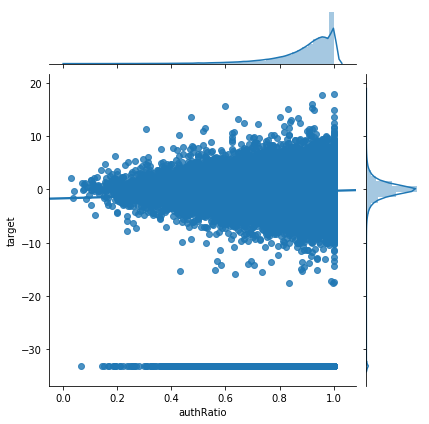

In [25]:
%time sns.jointplot(x=trainLabels['authRatio'], y=trainLabels['target'], kind='reg')

## 3. city id

In [16]:
edaViz.printUniqCount(histTrans[['city_id']])

city_id Unique :  
 [ 88 333   3  -1  69 233 322 138 226 330 278 221  19 331 211 209 193  11
 161 105 329  42 251 338 344  87  63 229 170 135 107  20  57  17 212 277
 280 117  85 301  25  86  96  38 283 116 188 250 231 158 272 311  49 296
 148  90 275 108  30 302 143  66 291 137 147   4 163  24 109 314 131   2
 144 340  62 160 157 216  53 149  47 169  14 342  26 120  56 162 213 259
 247 264 288  12 223 304 230 155 106 279 140  23  36 126 122  52 265  21
 173 318  48 261 129 199 286 245 244  18  51  58 248  80 295 159  13 276
 182 274  98 290 128 181 101 200  60 102 194 150 178 145 103 234 239 268
 335 156 339 334 242 184 168  78 232   7 111 285 115  89 119 253 300  33
 187 133 110 238 255  79  84  73 166  34 195   8 123 267  94 270 312 343
 210  46 214 258  65 136  75 224 104 100 328  64  41  74   1  76 271 179
   9 308 146 190 180 307  81 175 203 183 228 303 174 260 208 206  82 222
 313 289 294 266 124 309 186 298 287 325  10 139 167 281 151 246 292 171
 189 323 220 201  29  91  35 19

In [12]:
cityIdCnt

 69     4835441
-1      2478624
 19     1151077
 158    1113013
 17      971714
 331     714414
 143     668769
 88      659328
 137     603023
 333     561144
 87      444940
 212     406196
 57      382232
 149     359540
 25      356757
 233     355108
 117     322414
 160     317617
 213     248371
 277     247294
 286     231877
 76      216048
 4       212403
 107     210182
 53      209668
 20      207650
 291     199983
 140     190359
 344     177694
 161     168745
         ...   
 32        8382
 81        8278
 54        8201
 235       7918
 326       7912
 293       7804
 327       7499
 112       7461
 84        7367
 237       7285
 227       7233
 254       7143
 71        6781
 204       6745
 306       6128
 221       6096
 130       5657
 122       5458
 205       5385
 215       4791
 89        4760
 178       4430
 263       4003
 207       3905
 315       3845
 319       1645
 92         758
 273        620
 316        149
 185         45
Name: city_id, Length: 3

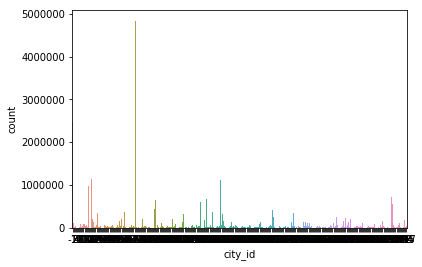

In [18]:
cityIdCnt = histTrans['city_id'].value_counts()
cityIdCnt = pd.DataFrame({'city_id': cityIdCnt.index, 'count':cityIdCnt})
sns.barplot(x=cityIdCnt['city_id'],y=cityIdCnt['count'])

In [27]:
%%time
cityIdGroup = histTrans[['card_id','city_id']].groupby(['card_id'])
trainLabels['cityIdMode'] = edaViz.mergeGroupby(trainLabels, cityIdGroup['city_id'], edaViz.mode)
testLabels['cityIdMode'] = edaViz.mergeGroupby(testLabels, cityIdGroup['city_id'], edaViz.mode)

Wall time: 19.4 s


Wall time: 2min 7s


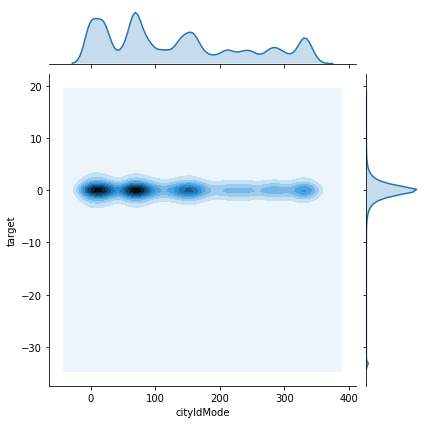

In [19]:
%time sns.jointplot(x=trainLabels['cityIdMode'], y=trainLabels['target'], kind='kde')

## 4. 